# Agent modeling

## Setup and Imports


In [ ]:
#@test {"output": "ignore"}
print('Installing dependencies...')
!apt-get update -qq && apt-get install -qq libfluidsynth1 fluid-soundfont-gm build-essential libasound2-dev libjack-dev
!pip install -qU pyfluidsynth pretty_midi

!pip install -qU magenta

# Hack to allow python to pick up the newly-installed fluidsynth lib. 
# This is only needed for the hosted Colab environment.
import ctypes.util
orig_ctypes_util_find_library = ctypes.util.find_library
def proxy_find_library(lib):
  if lib == 'fluidsynth':
    return 'libfluidsynth.so.1'
  else:
    return orig_ctypes_util_find_library(lib)
ctypes.util.find_library = proxy_find_library

print('Importing libraries and defining some helper functions...')
from google.colab import files

import magenta
import note_seq
import tensorflow

print('🎉 Done!')
print(magenta.__version__)
print(tensorflow.__version__)



Installing dependencies...
Importing libraries and defining some helper functions...
🎉 Done!
2.1.3
2.8.0


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install tqdm

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from tqdm import tqdm

## Function definitions

In [ ]:
def goalMapping(duration=1,sr=20500,type='constant',amplitude=1,offset=0,frequency=0.1):
    x = np.arange(duration*sr)/sr
    if type=='constant':
        y = offset * np.ones(duration*sr) 
    elif type == 'ramp':
        y = amplitude * x
    elif type=='sine':
        y = offset + amplitude * np.sin(2 * np.pi * frequency * x)
    elif type == 'sawtooth':
        y = offset + amplitude * signal.sawtooth(2 * np.pi * frequency * x)
    elif type == 'triangle':
        y = offset + amplitude * np.abs(signal.sawtooth(2 * np.pi * frequency * x))   
    elif type == 'square':
        y = offset + amplitude * signal.square(2 * np.pi * frequency * x)  
    return y 
    
def tempo_effect(action_history,n_lookback,sr):
    state = 1
    for k in range (action_history.shape[0]):
        if action_history[k] == 1:
            state += 1/sr
        else:
            state -= 1/sr
    return state
def update_state(action_history,trigger_times,effect_curve):
    #in order to update my state, i need to know which actions i picked,
    #when i picked them and what their effects are
    state = 0
    return state

def run(tension_curve=None,
        tension_multiplier=None,
        goal_p_value=None,
        goal_p_range = 0.1,
        tension_inc_scale=1,
        initial_state=0,
        mode='tempo',
        tempo_action=0,
        sr_global=20,
        episode_duration=10,
        n_lookback=4,
        action_rate=1,
        max_simult_actions=3):
    """
    Run the simulation. 
    """
    #add the tension effect corresponding to no action
    #tension_curve.insert(0,0)
    # action_history: array of start time lists for each action
    # we add a 0 in one of the subarrays for it to be stored as a list
    num_actions = len(tension_curve)
    num_steps = episode_duration*sr_global
    action_history = np.zeros((num_actions,num_steps))
    state_history = np.zeros(num_steps)
    tension_integral = np.array([np.trapz(tension_curve[i])  for i in range(num_actions)])
    tension_integral = np.multiply(tension_integral,tension_multiplier)
    state = initial_state #the state of the agent is the sum of the effect of its action w.r.t a defined property
    trigger_frames = []
    for i in range(num_actions):
        trigger_frames.append([])
    tension_increment = effect_increment_scale/sr_global
    tension_curve =  [tension_increment * tension_curve[i] * tension_multiplier[i] for i in range(len(tension_curve))] 
    for k in tqdm(range(num_steps)): 
        if mode == 'tempo':
            state = tempo_effect(action_history[tempo_action],n_lookback,sr_global)
            state_history[k] = state
            if k%(1/action_rate)==0:
                if state > goal_p_value[k]:
                    #if tempo too high, do not act
                    action = 0
                elif state < goal_p_value[k]:
                    #if tempo too low, act
                    action = tempo_action
                action_history[action,k]=1

                trigger_frames[action].append(k)
        elif mode == 'tension': 
            V = tension_integral
            if k == 0 or k % (1/action_rate)==0:                   
                if state > goal_p_value[k] + goal_p_range:
                    action = np.argmin(V)
                    action_history[action,k] = 1
                    trigger_frames[action].append(k)
                elif state < goal_p_value[k] - goal_p_range:
                    action = np.argmax(V)
                    action_history[action,k] = 1
                    trigger_frames[action].append(k) 
            
            for a in range(num_actions):
                for i in range(len(trigger_frames[a])):
                    if(len(trigger_frames[a])>0):
                        min = trigger_frames[a][i]
                        max = trigger_frames[a][i] + len(tension_curve[a])
                        
                        sampling_range = np.arange(min,max)
                        offset = trigger_frames[a][i]
                    else:
                        sampling_range = range(0)
                        offset = 0
                        state = state_history[k-1] 
                        state_history[k] = state
                    if k in sampling_range:
                        #sample tension_curve and add to state
                        k2 = librosa.frames_to_samples
                        state += tension_curve[a][k-offset]
                        state_history[k] = state
                    else:
                        #remove all previous action trigger frames
                        for m in range(k):
                            if m in trigger_frames[a]:
                                trigger_frames[a].remove(m)
        #Reset state
        # state = 0
    return (action_history,state_history)
def viz_episode(action_history=None,
                state_history=None,
                goal_p_value=None,
                sr_global=20,
                episode_duration=10,
                goal_p_range=0.1,
                mode='tempo'):
    x=np.arange(episode_duration*sr_global)/sr_global
    fig1, ax1 = plt.subplots(action_history.shape[0])
    fig2,ax2 = plt.subplots(1)
    ax2.plot(x,np.ones_like(x)*goal_p_value,label="goal_p_value")
    
    for i in range(action_history.shape[0]):
        ax1[i].scatter(x,action_history[i],label='action history'+ str(i))
        ax1[i].set_title("Action Activations ")
        ax1[i].legend(loc='lower left')
    if mode == 'tension':
        ax2.plot(x,goal_p_value+goal_p_range,label="goal_p_max")
        ax2.plot(x,goal_p_value-goal_p_range,label="goal_p_min")
    ax2.plot(x,state_history,label="state history")
    ax2.set_title("State History")
    ax2.legend(loc='lower left')
    fig2.set_figheight(7)
    fig2.set_figwidth(7)
    return 


## Compute Audio Features


tension_integral muffled_kick: 2468.528962676387
tension_integral snare_FPC: 941.7240496797951


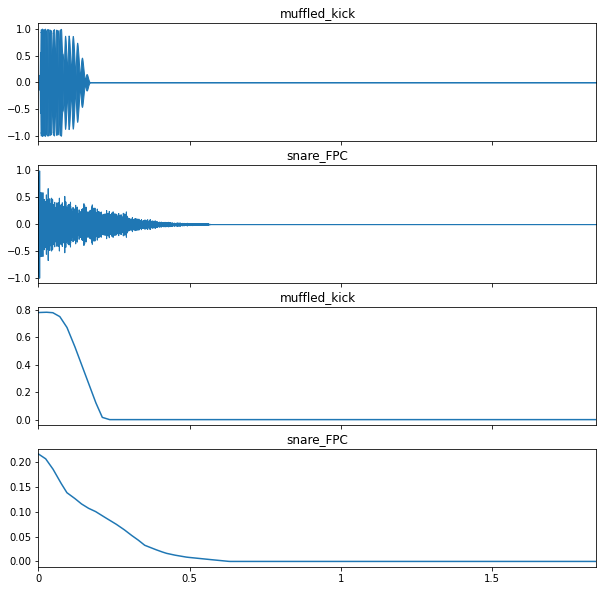

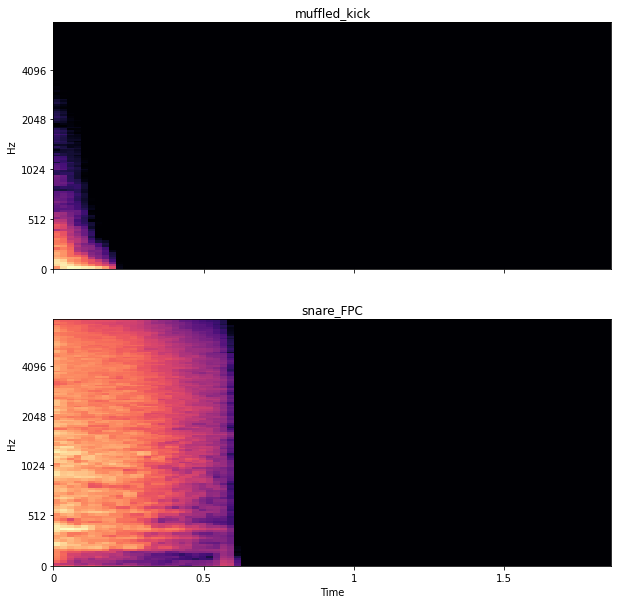

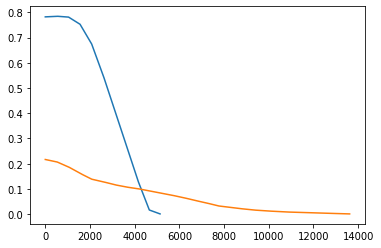

In [ ]:
import librosa, librosa.display
import IPython.display as ipd
from IPython.display import Audio
from scipy.signal import hilbert,resample
from scipy import interpolate
y_kick_802_2,sr = librosa.load('/content/drive/MyDrive/drum_samples/kick_802_2.wav')
snare_FPC,_ = librosa.load('/content/drive/MyDrive/drum_samples/snare_FPC.wav')
y_tom_16_inch_4,_ = librosa.load('/content/drive/MyDrive/drum_samples/tom_16_inch_tom_4.wav')
y_tom_909,_ = librosa.load('/content/drive/MyDrive/drum_samples/tom_909.wav')
muffled_kick,sr = librosa.load('/content/drive/MyDrive/drum_samples/muffled_kick.wav')
brake_sound,sr = librosa.load('/content/drive/MyDrive/drum_samples/422442__vacuumfan7072__jbrake-sim-96k.wav')
y_tom_909_envelope = hilbert(y_tom_909)

 

# y_kick_808, sr = librosa.load(kick_808_2)
# y_snare_lin, sr = librosa.load(snare_linn)
# y_tom_909, sr = librosa.load(tom_909)
# drum_samples = [muffled_kick,brake_sound,y_tom_16_inch_4,y_tom_909]
# drum_names = ['muffled_kick','brake_snare','y_tom_16_inch_4','tom_909']
drum_samples = [muffled_kick,snare_FPC]
drum_names = ['muffled_kick','snare_FPC']
rms = [None] * len(drum_samples)
effect_duration = [None] * len(drum_samples)
show_figs = True
if show_figs:
    fig, ax = plt.subplots(nrows=len(drum_samples)*2,sharex=True)
    fig.set_figheight(10)
    fig.set_figwidth(10)
    fig2, ax2 = plt.subplots(nrows=len(drum_samples),sharex=True)
    fig2.set_figheight(10)
    fig2.set_figwidth(10)
    fig3,ax3 = plt.subplots(nrows=1,sharex=True)
for i in range(len(drum_samples)):
    #set all max audio intensities to 1
    if np.max(np.abs(drum_samples[i]))>0:
        drum_samples[i] *= 1/np.max(drum_samples[i])
    S = librosa.feature.melspectrogram(y=drum_samples[i], sr=sr, n_mels=128,
                                    fmax=8000)
    rms[i] = librosa.feature.rms(y=drum_samples[i]).squeeze()
    times_audio = librosa.samples_to_time(np.arange(drum_samples[i].shape[0]),sr=sr)
    new_length = times_audio.size
    y_rms = rms[i]
    x_rms = np.arange(y_rms.size)
    new_x_rms = np.linspace(x_rms.min(),x_rms.max(), new_length)
    rms[i] = interpolate.interp1d(x_rms, y_rms, kind='linear')(new_x_rms)
    effect_duration[i] = librosa.samples_to_time(np.arange(rms[i].shape[0]),sr=sr)[-1]
    S_dB = librosa.power_to_db(S, ref=np.max)
    #plot
    if show_figs:
        librosa.display.waveplot(drum_samples[i], sr=sr, ax=ax[i])
        ax[i+2].plot(times_audio, rms[i], label='RMS Energy')
        ax[i].set(title=drum_names[i])
        ax[i].label_outer()
        ax[i+2].set(title=drum_names[i])
        ax[i+2].label_outer()
        img = librosa.display.specshow(S_dB, x_axis='time',

                            y_axis='mel', sr=sr,

                            fmax=8000, ax=ax2[i])
        ax2[i].set(title=drum_names[i])
        ax2[i].label_outer()
#Compute Audio Features 
rms_effect = []
rms_integral = []
lower_threshold = 0.001
num_action_effects = len(rms)
for i in range(num_action_effects):
    rms_ = rms[i].copy()
    rms_[np.where(rms_<lower_threshold)] = 0
    rms_ = np.trim_zeros(rms_)
    rms_effect.append(rms_)
    rms_integral.append(np.trapz(rms_))
    print('tension_integral '+drum_names[i]+':',np.trapz(rms_))
    ax3.plot(np.arange(rms_effect[i].size),rms_effect[i])

## Run Simulation

In [ ]:
sr_global = sr  #global sampling rate(s-1) 
action_rate = 0.0005 #effect curve sampling rate(s-1)
episode_duration = 20 #episode duration(s)
estimation_window = 1 #estimation window (s)
effect_increment_scale = 10  #amount by which our effect increases the state at each iteration
goal_p_value = goalMapping(duration=episode_duration,sr=sr_global,type='ramp',amplitude=2,offset=1,frequency=0.2)*goalMapping(duration=episode_duration,sr=sr_global,type='square',amplitude=1,offset=2,frequency=0.2)
goal_p_range = 1
tension_multiplier = np.ones(len(rms_effect))
#In this example, we consider associate "kicks","toms" as "contraction" or "compression" and "snares","claps" as "relaxation" or "expansion"
for i in range(len(drum_names)):
    drum_name = drum_names[i]
    if drum_name[i].find('kick') !=-1 or drum_name.find('tom') !=-1:
        tension_multiplier[i] = 1
    elif drum_name.find('snare') != -1 or drum_name.find('clap') != -1:
        tension_multiplier[i] = -4
tension_multiplier*= effect_increment_scale
action_history, state_history = run(goal_p_value=goal_p_value,
        tension_inc_scale=effect_increment_scale,
        tension_curve=rms_effect,
        tension_multiplier=tension_multiplier,
        initial_state=1,
        goal_p_range = goal_p_range,
        mode='tension',
        tempo_action=0,
        sr_global=sr_global,
        episode_duration=episode_duration,
        n_lookback=4,
        action_rate=action_rate)


100%|██████████| 441000/441000 [00:26<00:00, 16496.20it/s]


(array([ 10000,  12000,  24000,  32000,  34000,  40000,  50000,  56000,
        58000,  64000,  70000,  72000,  86000,  88000,  96000, 102000,
       104000, 118000, 124000, 132000, 134000, 144000, 156000, 158000,
       166000, 168000, 170000, 172000, 180000, 186000, 188000, 196000,
       202000, 204000, 212000, 218000, 220000, 240000, 246000, 254000,
       256000, 266000, 268000, 274000, 276000, 278000, 280000, 282000,
       290000, 296000, 304000, 310000, 318000, 324000, 350000, 352000,
       364000, 366000, 376000, 378000, 384000, 386000, 388000, 390000,
       392000, 394000, 396000, 404000, 408000, 414000, 422000, 428000,
       436000, 438000]),)


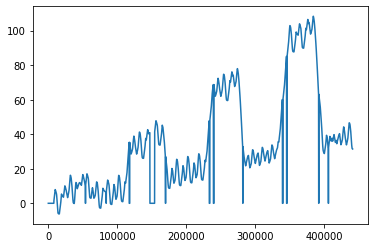

In [ ]:
x_f = np.arange(action_history[0].shape[0])
# plt.plot(x_f,action_history[0])
plt.plot(np.arange(state_history[:].shape[0]),state_history[:])
print(np.where(action_history[1]>0))

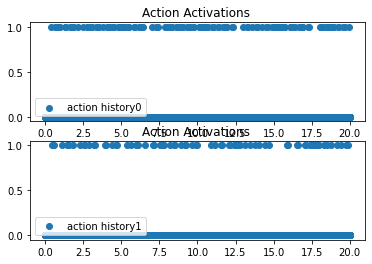

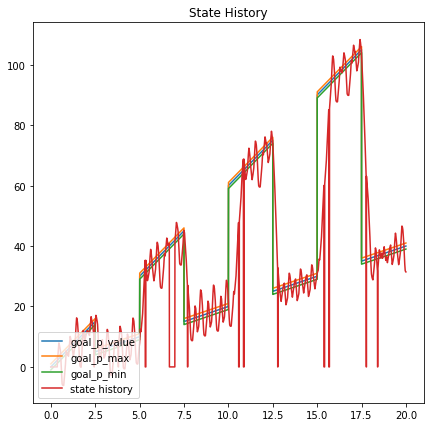

In [ ]:
viz_episode(action_history=action_history,
                state_history=state_history,
                goal_p_value=goal_p_value,
                sr_global=sr_global,
                episode_duration=episode_duration,
                goal_p_range=goal_p_range,
                mode='tension')

## Export MIDI files

For a tutorial see [hello mangenta](https://colab.research.google.com/drive/1_6Is2gcnpAWuWQ6g-vf9LRSlnOLB2V8j#scrollTo=PfRDVhNs3UFx) notebook

In [ ]:
from note_seq.protobuf import music_pb2
import note_seq
drums = music_pb2.NoteSequence()
# Add the notes to the sequence.
#from https://github.com/magenta/note-seq/blob/a715b102e84f36057474fe1be8f4e3c2af4cb7c3/note_seq/testing_lib.py#L33
DEFAULT_DRUM_TYPE_PITCHES = [
    # kick drum
    [36, 35],

    # snare drum
    [38, 27, 28, 31, 32, 33, 34, 37, 39, 40, 56, 65, 66, 75, 85],

    # closed hi-hat
    [42, 44, 54, 68, 69, 70, 71, 73, 78, 80, 22],

    # open hi-hat
    [46, 67, 72, 74, 79, 81, 26],

    # low tom
    [45, 29, 41, 43, 61, 64, 84],

    # mid tom
    [48, 47, 60, 63, 77, 86, 87],

    # high tom
    [50, 30, 62, 76, 83],

    # crash cymbal
    [49, 52, 55, 57, 58],

    # ride cymbal
    [51, 53, 59, 82]
]
mode = "drums"
save_drums = True
new_y = np.array(action_history[0]*1 + action_history[1]*2,dtype='int32')
note_times = np.array([1/sr_global,effect_duration[0],effect_duration[1]])
sequence = music_pb2.NoteSequence()
drums = music_pb2.NoteSequence()
current_time = 0
if mode == "note":
    action_pitches = [0,40,60]
    action_velocities = [0,20,20]
    for i in range(len(new_y)):
        if new_y[i]>0:
            sequence.notes.add(pitch=action_pitches[new_y[i]], start_time=current_time, end_time= current_time + note_times[new_y[i]], velocity=20)
        current_time += 1/sr_global
elif mode == "drums":
    action_pitches = [0,DEFAULT_DRUM_TYPE_PITCHES[0][1] ,DEFAULT_DRUM_TYPE_PITCHES[2][7]]
    action_velocities = [0,20,20]
    for i in range(len(new_y)):
        if new_y[i]>0:
            sequence.notes.add(pitch=action_pitches[new_y[i]], start_time=current_time, end_time= current_time + note_times[new_y[i]],is_drum=True, instrument=new_y[i], velocity=20)
            if save_drums:
                drums.notes.add(pitch=60, start_time=current_time, end_time= current_time + note_times[new_y[i]],is_drum=True, instrument=new_y[i], velocity=20)
        current_time += 1/sr_global   

# for i in range(len(new_y)):
#     drums[new_y[i]].notes.add(pitch=60, start_time=current_time, end_time= current_time + note_time, is_drum=True, instrument=10, velocity=20)
#     current_time += note_time 
    
if save_drums:
    drums.tempos.add(qpm=60)
    midi_filename = 'drums_sequence_output.mid'
    note_seq.sequence_proto_to_midi_file(drums, midi_filename)
    files.download(midi_filename)
# This is a colab utility method that visualizes a NoteSequence.
note_seq.plot_sequence(sequence)

# This is a colab utility method that plays a NoteSequence.
note_seq.play_sequence(sequence,synth=note_seq.fluidsynth)
# note_seq.sequence_proto_to_midi_file(sequence, mode + '_sample_output.mid')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

04/24/2022 NOTES:
The level of refinement of the features is much greater than the level of refinement of the action selection.
I must either simplify my features/effects, or increase the number of actions to choose from and improve the action selection algorithm for it to be more situationally aware.